##Data Collection

A custom crypto dataset listing the addresses and the type of coin in random order was generated in the ```data-collection.ipynb``` file.
Data was originally collected from Google's BigQuery datasets for four types of crypto coins - bitcoin, ethereum, dogecoin, and litecoin.

The data is stored into a pandas dataframe ```data```.

In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv('/content/crypto-dataset.csv')
print(data.shape)
data.head()

(20152, 2)


,addresses,crypto type
0,DMN4dtPexpnxPKxBkm1RBzeuKNthrrbwMY,DOGE
1,DDiFMZiC6r1gP6kWmEaKaHVJx66dKut6z9,DOGE
2,0xfdb05da0e8b2c0183d88ae053ab8767cddf03b53,ETH
3,0x92501ef67a738dd83d0adb14ddb905487ccecac8,ETH
4,0xa3d948146e1d10402d361253a79835e5de25b822,ETH


In [ ]:
data.rename(columns={'crypto type': 'label'}, inplace=True)
data.head(-5)

,addresses,label
0,DMN4dtPexpnxPKxBkm1RBzeuKNthrrbwMY,DOGE
1,DDiFMZiC6r1gP6kWmEaKaHVJx66dKut6z9,DOGE
2,0xfdb05da0e8b2c0183d88ae053ab8767cddf03b53,ETH
3,0x92501ef67a738dd83d0adb14ddb905487ccecac8,ETH
4,0xa3d948146e1d10402d361253a79835e5de25b822,ETH
...,...,...
20142,D7SqVcj1CdAcy7rDF5Q4GuK2wJ4vYxaoCt,DOGE
20143,DAfxvqg1tVSVEtnhdFFtX8vGdJw2d72sHi,DOGE
20144,bc1q3gvzenm943ggcxsajpqk3667cqja8k2jgy94am,BTC
20145,LfdGbSmoGrKSetZY2LeiuHo8wagm2364bz,LTC


All rows with a NaN value in the ```addresses``` column need to be removed.

In [ ]:
data = data.dropna(subset=['addresses'])
data.head(-5)

,addresses,label
0,DMN4dtPexpnxPKxBkm1RBzeuKNthrrbwMY,DOGE
1,DDiFMZiC6r1gP6kWmEaKaHVJx66dKut6z9,DOGE
2,0xfdb05da0e8b2c0183d88ae053ab8767cddf03b53,ETH
3,0x92501ef67a738dd83d0adb14ddb905487ccecac8,ETH
4,0xa3d948146e1d10402d361253a79835e5de25b822,ETH
...,...,...
20142,D7SqVcj1CdAcy7rDF5Q4GuK2wJ4vYxaoCt,DOGE
20143,DAfxvqg1tVSVEtnhdFFtX8vGdJw2d72sHi,DOGE
20144,bc1q3gvzenm943ggcxsajpqk3667cqja8k2jgy94am,BTC
20145,LfdGbSmoGrKSetZY2LeiuHo8wagm2364bz,LTC


##Data Preprocessing

The ```sanitize_addresses``` function takes the address and checks for some basic bounds.
1. The addresses should be between 26 and 42 characters, as gathered from https://hackernoon.com/educational-byte-what-is-a-crypto-address-and-how-to-recognize-different-types
2. The addresses should not contain invalid characters, like special characters.

Additionally, it also removes any whitespace from wither side of the addresses and converts them into lowercase.

In [ ]:
import re

def sanitize_addresses(address, label):
  '''
  Removes invalid characters and ensures address length is within reasonable bounds.
  '''
  address = address.strip()
  if not re.match(r'^[a-zA-Z0-9]+$', address):
    return None
  if len(address) < 26 or len(address) > 42:
    return None
  return address.lower()

The addresses that pass the sanitization are allowed to stay in a new dataframe ```df```.

In [ ]:
df = pd.DataFrame(columns=['addresses', 'label'])

for entry in data.itertuples():
  address = entry.addresses
  label = entry.label

  sanitized_address = sanitize_addresses(address, label)
  if not sanitized_address:
    continue

  df.loc[len(df)] = {'addresses': sanitized_address, 'label': label}

In [ ]:
df.shape

(19254, 2)

After sanitization, a countplot tells us how many addresses of each label survived in the new dataframe.

<Axes: xlabel='label', ylabel='count'>

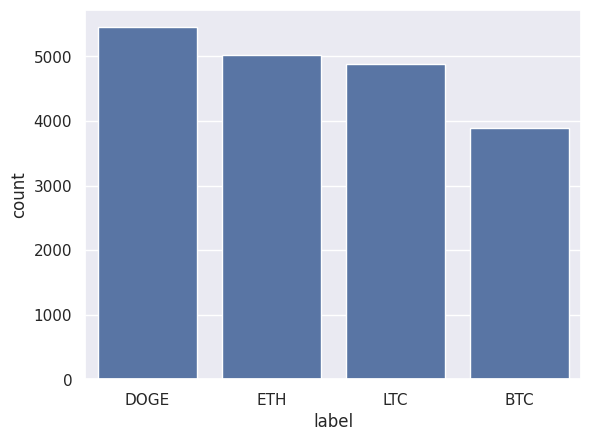

In [ ]:
import seaborn as sns

sns.set()

sns.countplot(x="label", data=df)

###Feature Engineering

Now, it is time for some feature engineering. Here, we will aim to extract relevant features from cryptocurrency addresses to help in distinguishing between different types.
<br>
Feature engineering involves transforming raw data (cryptocurrency addresses) into a format that can be used by machine learning algorithms.

For this problem, the following substeps were performed for feature transformation:
1. Extract the length of each cryptocurrency address as a feature.
2. Calculate the frequency of each character in the address.
3. Extract the prefix of the address which can be indicative of the type of cryptocurrency, as gathered from [here](https://hackernoon.com/educational-byte-what-is-a-crypto-address-and-how-to-recognize-different-types).

In [ ]:
def get_address_length(address):
  """
  Calculate the length of a cryptocurrency address.

  Parameters:
  address (str): The cryptocurrency address.

  Returns:
  int: The length of the address.
  """
  return len(address)

from collections import Counter

def get_character_frequency(address):
  """
  Calculate the frequency of each character in the cryptocurrency address.

  Parameters:
  address (str): The cryptocurrency address.

  Returns:
  dict: A dictionary with characters as keys and their frequencies as values.
  """
  frequency = Counter(address)
  return frequency

def get_address_prefix(address, length):
  """
  Extract the prefix of a cryptocurrency address.

  Parameters:
  address (str): The cryptocurrency address.
  length (int): The length of the prefix to extract.

  Returns:
  str: The prefix of the address.
  """
  return address[:length]

Now, we will combine all the extracted features into a single feature vector.

In [ ]:
def extract_features(address, label):
  """
  Extract all relevant features from a cryptocurrency address.

  Parameters:
  address (str): The cryptocurrency address.

  Returns:
  length (int):
  char_freq_vector:
  prefix:
  """
  length = get_address_length(address)
  char_freq = get_character_frequency(address)

  if label == 'BTC':
    if address[0].isdigit():
      prefix = get_address_prefix(address, 1)
    else:
      prefix = get_address_prefix(address, 3)
  elif label == 'ETH':
    prefix = get_address_prefix(address, 2)
  else:
    prefix = get_address_prefix(address, 1)

  # Convert character frequency to a fixed-length vector (e.g., 256 for ASCII)
  char_freq_vector = np.zeros(256)
  for char, freq in char_freq.items():
      char_freq_vector[ord(char)] = freq

  return length, char_freq_vector, prefix

In [ ]:
# Extract features for each address
features = pd.DataFrame(columns=['length', 'character fequency', 'prefix'])
for entry in df.itertuples():
  address = entry.addresses
  label = entry.label
  length, char_freq_vector, prefix = extract_features(address, label)
  features.loc[len(features)] = {'length': length, 'character fequency': char_freq_vector, 'prefix': prefix}

features.head()

,length,character fequency,prefix
0,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",d
1,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",d
2,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0x
3,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0x
4,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0x


The ```features``` dataframe is now concatenated with the ```df``` dataframe.
The resultant dataframe is stored into ```crypto_df```.

In [ ]:
crypto_df = pd.concat([df, features], axis=1)

In [ ]:
crypto_df.head(-5)

,addresses,label,length,character fequency,prefix
0,dmn4dtpexpnxpkxbkm1rbzeuknthrrbwmy,DOGE,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",d
1,ddifmzic6r1gp6kwmeakahvjx66dkut6z9,DOGE,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",d
2,0xfdb05da0e8b2c0183d88ae053ab8767cddf03b53,ETH,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0x
3,0x92501ef67a738dd83d0adb14ddb905487ccecac8,ETH,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0x
4,0xa3d948146e1d10402d361253a79835e5de25b822,ETH,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0x
...,...,...,...,...,...
19244,d7sqvcj1cdacy7rdf5q4guk2wj4vyxaoct,DOGE,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",d
19245,dafxvqg1tvsvetnhdfftx8vgdjw2d72shi,DOGE,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",d
19246,bc1q3gvzenm943ggcxsajpqk3667cqja8k2jgy94am,BTC,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",bc1
19247,lfdgbsmogrksetzy2leiuho8wagm2364bz,LTC,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",l


Since most machine learning algorithms in libraries like scikit-learn will not accept it directly because they require numerical inputs. To handle this, we need to convert these string elements into a numerical format.

One common approach is to use one-hot encoding.
One-hot encoding converts categorical variables into a binary (0 or 1) matrix. Each unique category value becomes a column, and the presence of that category is marked with a 1 in the respective column.

Here, we can handle the prefix column using one-hot encoding and integrate it into your machine learning pipeline.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X = crypto_df.drop(columns=['addresses', 'label'], axis=1)

In [ ]:
one_hot_encoder = OneHotEncoder()
prefix_encoded = one_hot_encoder.fit_transform(X[['prefix']]).toarray()

# Create a DataFrame for the encoded prefix columns
prefix_columns = [f'prefix_{category}' for category in one_hot_encoder.categories_[0]]
prefix_df = pd.DataFrame(prefix_encoded, columns=prefix_columns)

prefix_df.head(-5)

,prefix_0x,prefix_1,prefix_3,prefix_9,prefix_a,prefix_bc1,prefix_d,prefix_l
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
19244,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19245,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19246,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Drop the original 'prefix' column and concatenate the new one-hot encoded columns
X = X.drop(columns=['prefix'])
X = pd.concat([X, prefix_df], axis=1)
X.head(-5)

,length,character fequency,prefix_0x,prefix_1,prefix_3,prefix_9,prefix_a,prefix_bc1,prefix_d,prefix_l
0,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
19244,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19245,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19246,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19247,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


When working with machine learning models in libraries like scikit-learn, feature vectors should also be in a format that the algorithms can process. Specifically, each feature should be a numerical value, and each sample should be represented as a flat vector. The ```character fequency``` column contains arrays, so we need to ensure these arrays are properly formatted into a 2D array where each row corresponds to a sample and each column corresponds to a feature.

In [ ]:
char_freq_vectors = np.array(X['character fequency'].tolist())

# Other features (assuming they are already extracted and available)
other_features = X[['length', 'prefix_0x', 'prefix_1', 'prefix_3', 'prefix_9', 'prefix_a', 'prefix_bc1', 'prefix_d', 'prefix_l']].values

# Combine all features into a single feature matrix
X = np.hstack([char_freq_vectors, other_features])

In [ ]:
X[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  2.,  2.,  0.,  0.,
        1.,  0.,  0.,  3.,  0.,  3.,  3.,  0.,  3.,  0.,  3.,  0.,  2.,
        1.,  0.,  1.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

The label is segregated into a separate ```y``` variable, which is then converted into a numpy array.

In [ ]:
y = crypto_df['label']
y = y.to_numpy()

##Model Selection and Training

This step involves selecting appropriate machine learning models, training them on the preprocessed and feature-engineered data, and tuning their hyperparameters to achieve the best performance.

Here the data has already been prepared and the feature matrix ```X``` and the target vector ```y``` is ready.

1. Split the dataset into training and validation sets.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

2. We have chosen a few common machine learning algorithms for the classification task. They are:
* Decision Trees
* Random Forests
* Support Vector Machines (SVM)
* Neural Networks

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

3. Train each selected model on the training data.

In [ ]:
# Train a Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train, y_train.reshape(-1))

# Train a Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

# Train a Support Vector Machine classifier
svm = SVC(random_state=42)
svm.fit(x_train, y_train)

# Train a Neural Network classifier
mlp = MLPClassifier(random_state=42, max_iter=300)
mlp.fit(x_train, y_train)

MLPClassifier(max_iter=300, random_state=42)

4. We will use grid search to find the best hyperparameters for each model.
<br>** This step is computationally expensive and should be done carefully. **

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}

# Grid search for Random Forest
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(x_train, y_train)

# The best hyperparameters
print("Best parameters for Random Forest:", grid_search_rf.best_params_)


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# # Grid search for SVM
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1)
grid_search_svm.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'linear']})

In [164]:
print("Best parameters for SVM:", grid_search_svm.best_params_)

Best parameters for SVM: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}


Evaluate the trained models on the validation set using appropriate metrics such as accuracy, precision, recall, F1-score, and confusion matrix.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate Decision Tree
y_pred_dt = dt.predict(x_val)
print("Decision Tree Accuracy:", accuracy_score(y_val, y_pred_dt))
print("Decision Tree Classification Report:\n", classification_report(y_val, y_pred_dt))
print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_val, y_pred_dt))

# Evaluate Random Forest (using the best parameters from grid search)
y_pred_rf = grid_search_rf.predict(x_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_val, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))

# Evaluate SVM (using the best parameters from grid search)
y_pred_svm = grid_search_svm.predict(x_val)
print("SVM Accuracy:", accuracy_score(y_val, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_val, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_val, y_pred_svm))

# Evaluate Neural Network
y_pred_mlp = mlp.predict(x_val)
print("Neural Network Accuracy:", accuracy_score(y_val, y_pred_mlp))
print("Neural Network Classification Report:\n", classification_report(y_val, y_pred_mlp))
print("Neural Network Confusion Matrix:\n", confusion_matrix(y_val, y_pred_mlp))

Decision Tree Accuracy: 1.0
Decision Tree Classification Report:
               precision    recall  f1-score   support

         BTC       1.00      1.00      1.00       767
        DOGE       1.00      1.00      1.00      1100
         ETH       1.00      1.00      1.00      1028
         LTC       1.00      1.00      1.00       956

    accuracy                           1.00      3851
   macro avg       1.00      1.00      1.00      3851
weighted avg       1.00      1.00      1.00      3851

Decision Tree Confusion Matrix:
 [[ 767    0    0    0]
 [   0 1100    0    0]
 [   0    0 1028    0]
 [   0    0    0  956]]
Random Forest Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

         BTC       1.00      1.00      1.00       767
        DOGE       1.00      1.00      1.00      1100
         ETH       1.00      1.00      1.00      1028
         LTC       1.00      1.00      1.00       956

    accuracy                       

Getting feature importance of each feature and exporting it to a separate ```.csv``` file.

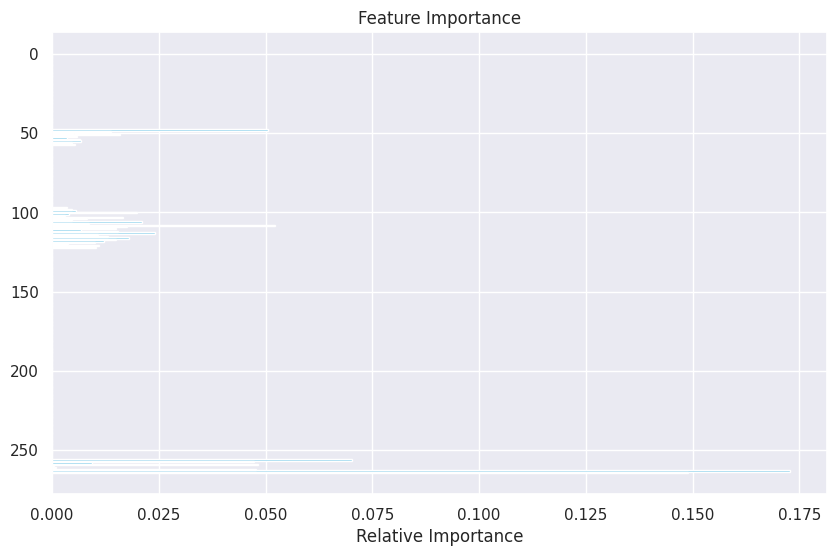

In [168]:
import matplotlib.pyplot as plt

# Extract Feature Importance
importances = rf.feature_importances_
X_df = pd.DataFrame(X)
feature_names = X_df.columns

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel('Relative Importance')
plt.show()

# Optional: Save the feature importance to a CSV
feature_importances.to_csv('feature_importances.csv', index=False)

###Save the trained model

Serialize the trained model using a tool like ```joblib``` or ```pickle```.
This allows the model to be easily loaded for inference.

In [ ]:
import joblib

# Serialize the random forest model to a file
joblib.dump(grid_search_rf.best_estimator_, 'random_forest_model.pkl')

# Serialize the SVM model
joblib.dump(grid_search_svm.best_estimator_, 'svm_model.pkl')

# Serialize the Decision Tree model
joblib.dump(dt, 'decision_tree_model.pkl')

# Serialize the Neural Network model
joblib.dump(mlp, 'neural_network_model.pkl')

['neural_network_model.pkl']